`Дан датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.`

- таблица ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах

`С помощью pandahouse выгрузим нужные данные из ClickHouse и проанализируем их в python.` 

In [1]:
#импортируем нужные библиотеки
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import plotly as plt
import matplotlib.pyplot as plt

In [2]:
# Объявим параметры для подключения 
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

**Задание_1.** Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [3]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT count(id)
FROM default.ldn_listings
"""
df_count_string = ph.read_clickhouse(query, connection=connection_default)
df_count_string

,count(id)
0,85207


**Задание_2.** Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

- price – цена за ночь
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [4]:
query_2 = """
SELECT 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
FROM 
    default.ldn_listings
order by id asc 
limit 1000
"""
df_2 = ph.read_clickhouse(query_2, connection=connection_default)
df_2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [5]:
# посчитаем 75-й перцентиль цены
df_2.groupby('room_type', as_index=False).quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


**Задание_3.** К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Постройте график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [6]:
query_3 = """
SELECT 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM 
    default.ldn_listings
where review_scores_rating is not null
order by id asc 
limit 1000
"""
df_3 = ph.read_clickhouse(query_3, connection=connection_default)
df_3

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [9]:
# сгруппируем датафрейм по типу жилья и посчитаем среднее для цены и рейтинга 
df_3_mean = df_3.groupby('room_type', as_index=False)\
                .agg({'price':'mean',
                      'review_scores_rating':'mean'})
df_3_mean

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


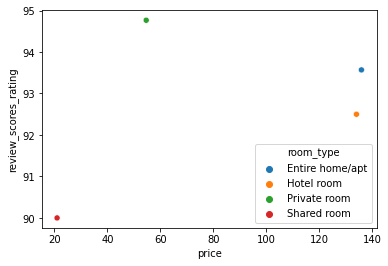

In [10]:
sns.scatterplot(data = df_3_mean, x = 'price', y = 'review_scores_rating', hue = 'room_type')

**Задание_4.** Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

- host_id – идентификатор хозяина (уникальный)
- host_verifications – какими способами хост подтвердил свой профиль

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [28]:
query_4 = """
select 
    host_id, 
    host_verifications
from 
    default.ldn_listings
where experiences_offered != 'none'
"""
df_4 = ph.read_clickhouse(query_4, connection=connection_default)
df_4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1543,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1544,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."
1545,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."
1546,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."


In [29]:
# строковые представления списка приведём к настоящему списку
# strip() чтобы удалить символы с начала и конца строки 
# split() чтобы разделить строку в массив по переданному разделителю
df_4['host_verifications'] = df_4['host_verifications'].apply(lambda x: x.strip("[]").split(', '))

In [34]:
# explode - преобразуем из списка в отдельные строки и подсчитае сколько раз встречается каждый способ верификации
df_4.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')

,count
'phone',1548
'email',1531
'reviews',1493
'government_id',1373
'jumio',1279
'offline_government_id',573
'work_email',322
'facebook',307
'selfie',300
'identity_manual',272


**Задание_5.** Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [35]:
query_5 = """
select 
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) as experiences_count
from 
    default.ldn_listings
where experiences_offered != 'none'
group by neighbourhood_cleansed, experiences_offered
order by experiences_count desc
limit 100
"""
df_5 = ph.read_clickhouse(query_5, connection=connection_default)
df_5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [37]:
df_5_pivot = df_5.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered' ,values = 'experiences_count')
df_5_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


In [38]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,30)}
    )


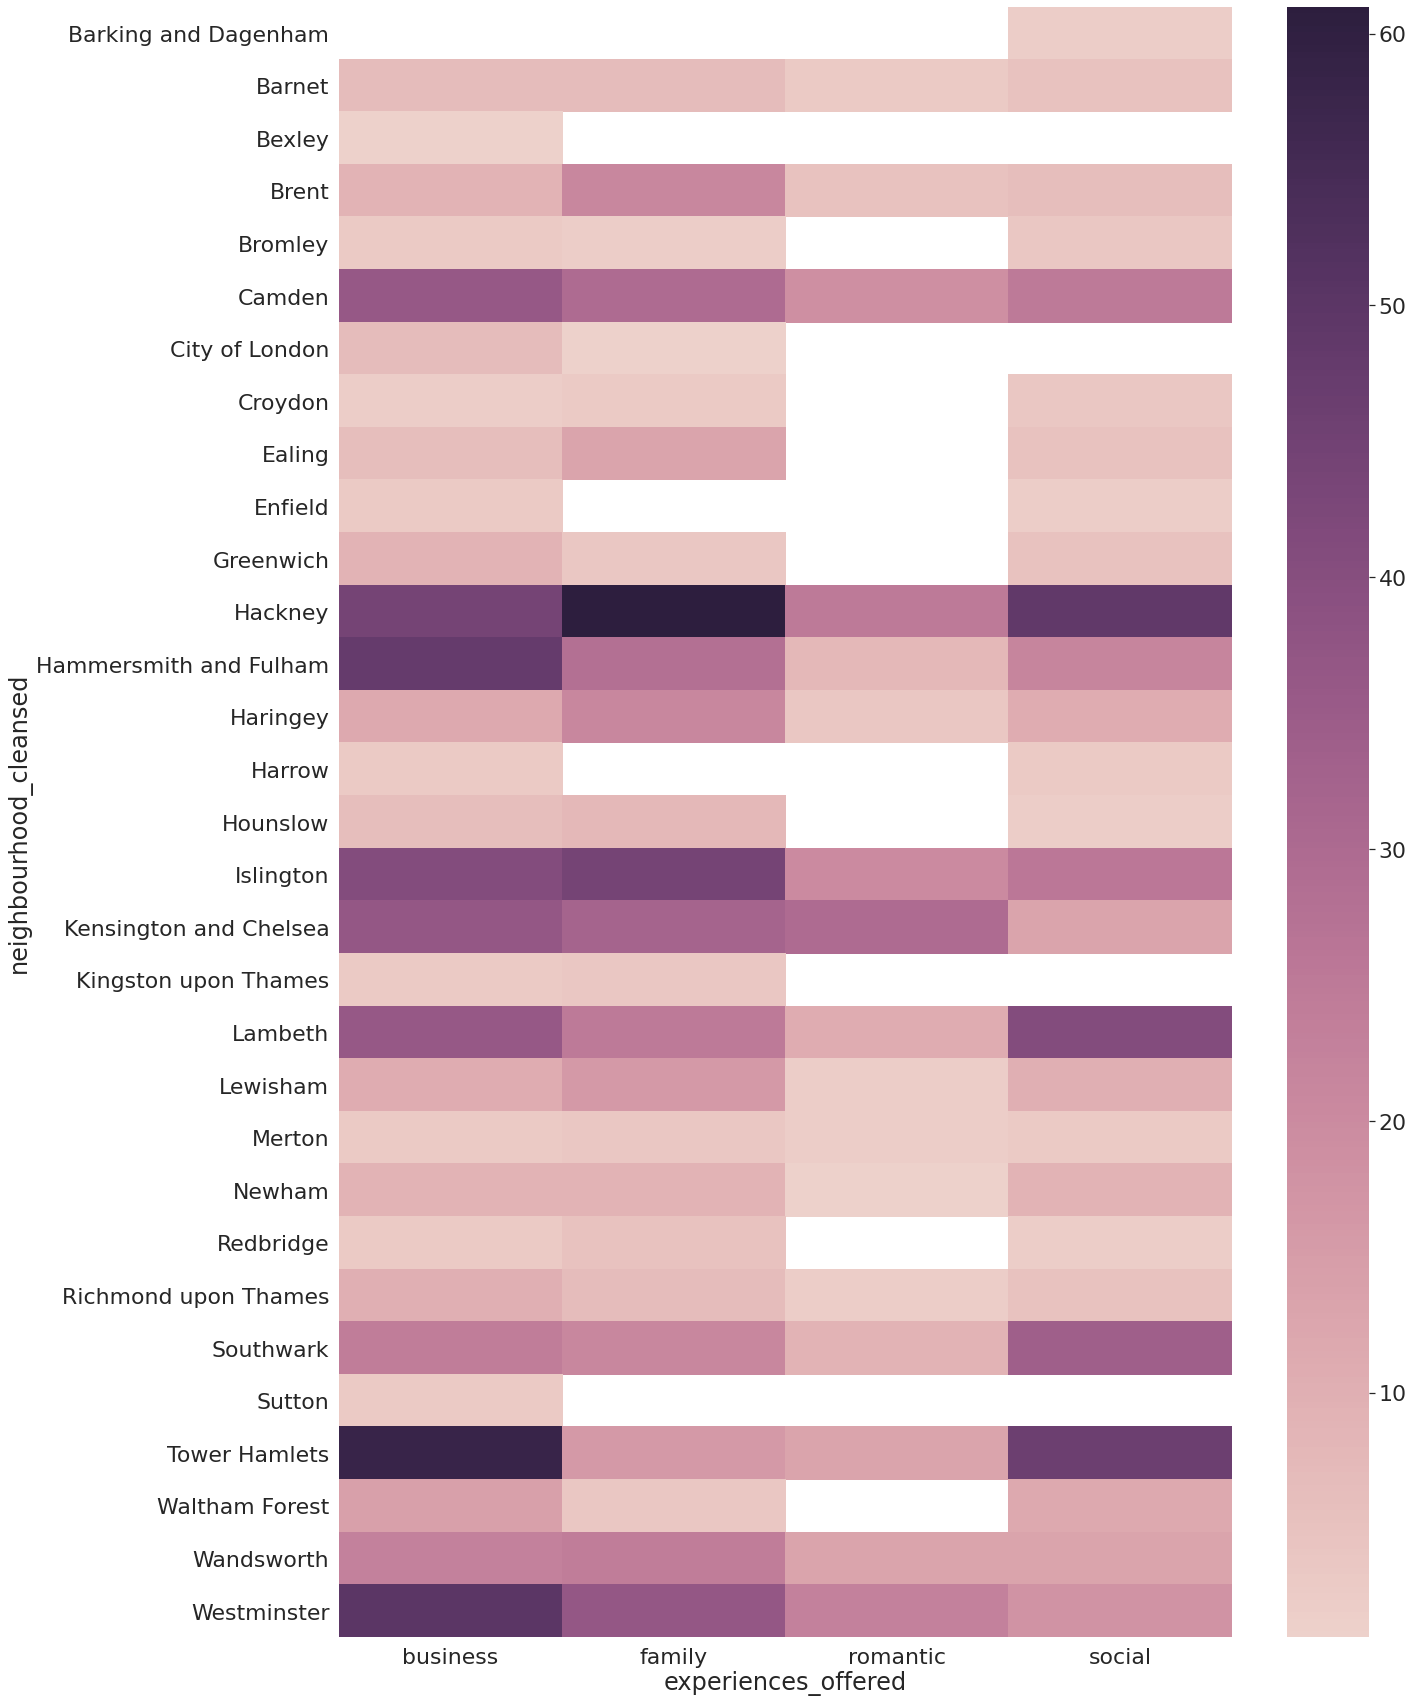

In [40]:
sns.heatmap(df_5_pivot,cmap=sns.cubehelix_palette(as_cmap=True))

**Задание_6.** Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь 
- experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

- На первом отобразите исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения (np.log())

In [41]:
query_6 = """
select 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price_corr
from 
    default.ldn_listings
where experiences_offered != 'none'
"""
df_6 = ph.read_clickhouse(query_6, connection=connection_default)
df_6

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [44]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,10)}
       )

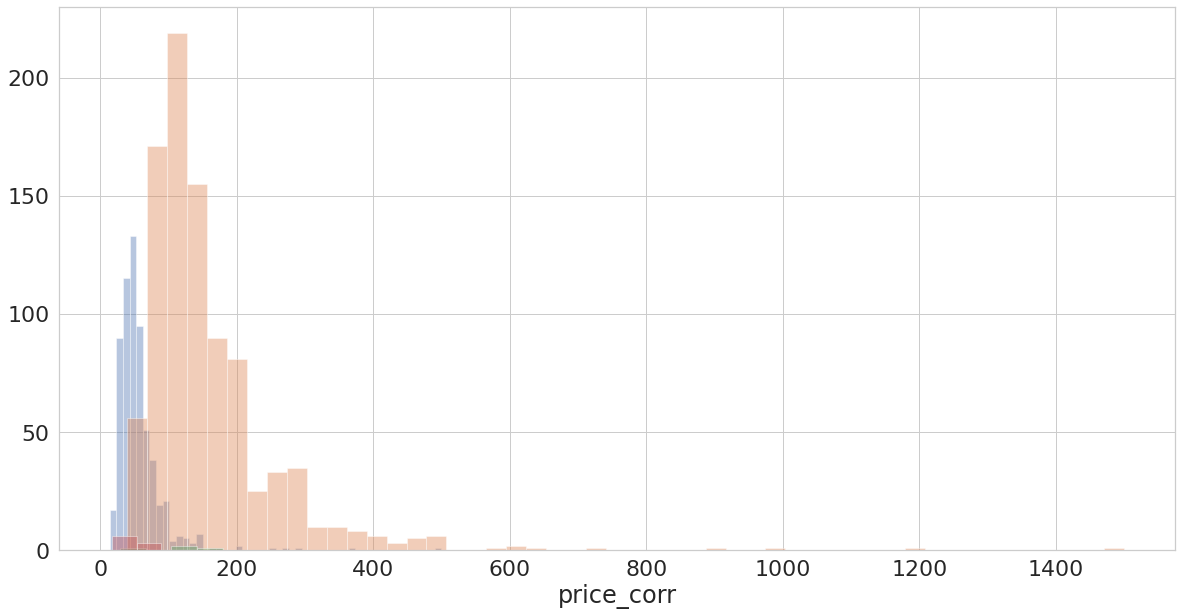

In [50]:
# исходные распределения цен для каждого типа жилья
sns.distplot(df_6.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(df_6.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(df_6.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')
sns.distplot(df_6.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


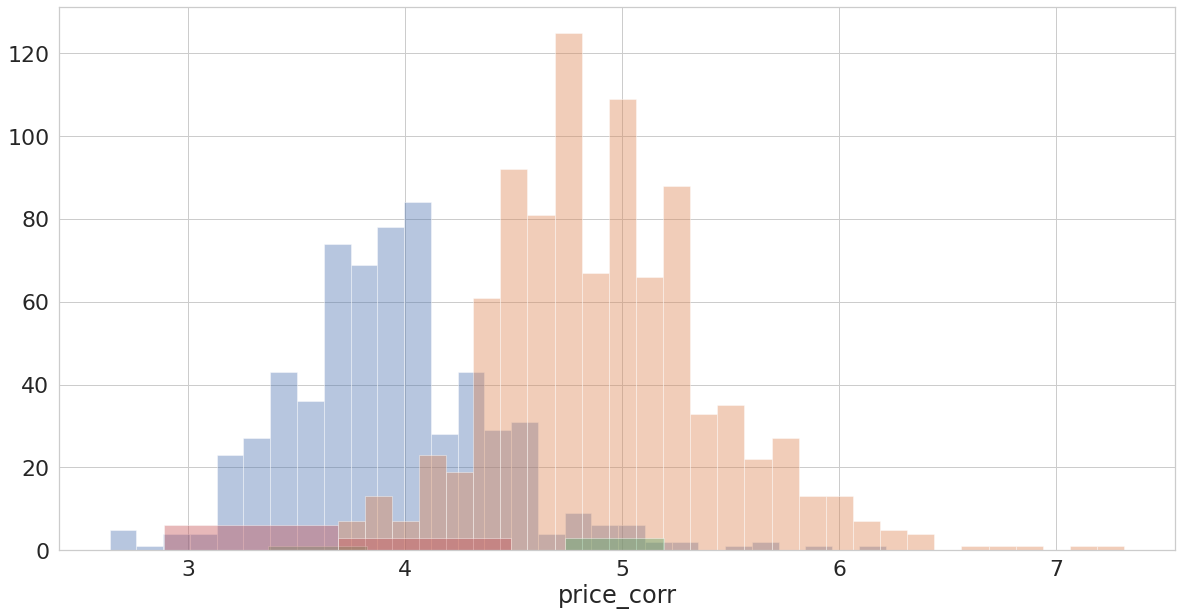

In [56]:
#логарифмированные значения 
sns.distplot(np.log(df_6.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(df_6.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_6.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')
sns.distplot(np.log(df_6.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')

**Задание_7.** Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь
- first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [58]:
query_7 = """
select 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price_corr,
    toDateOrZero(first_review) as first_review
from 
    default.ldn_listings
where first_review > '2010-01-01'
limit 1000
"""
df_7 = ph.read_clickhouse(query_7, connection=connection_default)
df_7

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


Построим график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам. 

In [59]:
df_7['first_review'] = df_7['first_review'].apply(lambda x: x.year)
df_7

,room_type,price_corr,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [61]:
df_7.groupby(['room_type','first_review'])\
.agg({'price_corr':'mean'})

price_corr
room_type       first_review            
Entire home/apt 2010          103.500000
                2011          128.792450
                2012          135.467255
                2013          137.887634
                2014          154.583328
                2015          159.380951
                2016           99.733330
                2017          111.666664
                2018          125.066666
                2019          301.666656
                2020           50.000000
Hotel room      2010           88.000000
                2017          180.000000
Private room    2010           56.428570
                2011           52.607143
                2012           53.269840
                2013           57.036587
                2014           56.842106
                2015           48.058823
                2016           57.307693
                2017           51.142857
                2018           55.416668
                2019           74.000000
                2020           39.000000
Shared room     2012           22.000000
                2014           20.000000

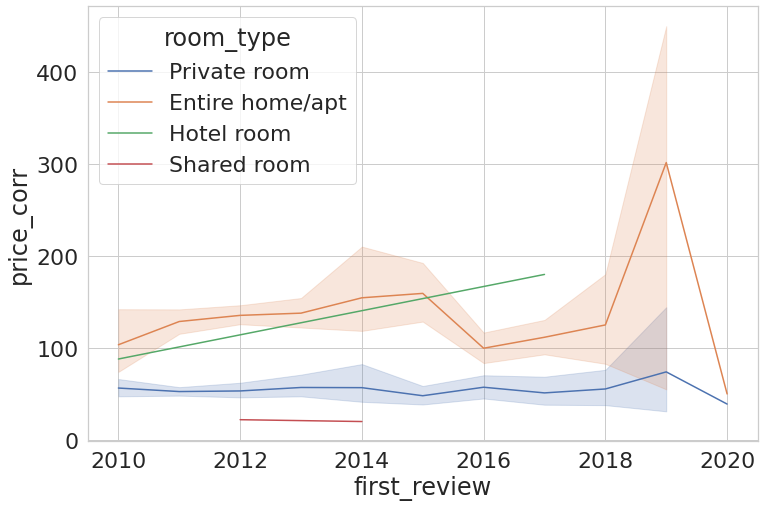

In [54]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price_corr',hue='room_type',data=df_7)